# TRAIN WRITER RECOGNITON
Requires:

1. Folder of images relative to top level folder DATA_FOLDER
2. A label file(TRAINING_DATA_FILE) which has at least two comma separated columns: path and ontology_id


The ontology_is the numeric writer id from 0 to N-1 for N writers known for training
The path is relative to the DATA_FOLDER

The training data file may also contain other helpful columns not used in training such as the actual writer name of string id.

In [1]:
DATA_FOLDER = '/data/iam_data/'
#which writers are held out for training
MAX_WRITER_ID = 50
# training file
TRAINING_DATA_FILE = 'anonname_to_filename_mapping_full_path.csv'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 


In [3]:
from __future__ import division
import numpy as np
import os
import glob
from keras.utils import to_categorical, np_utils
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers.schedules import LearningRateSchedule
import pandas as pd

/home/robertsone/HWR/writer_identification/wi/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
from model import build_model

In [5]:
df=pd.read_csv(f'{DATA_FOLDER}/{TRAINING_DATA_FILE}')
df_train = df.loc[df["path"].str.startswith('lines_fixed/')]
print(len(df_train))
df.astype({'ontology_id': 'int'})
df_train.head()

13353


,annonymous_id,path,md5,ontology_id,source,class,usage
292768,3cca0fdf-a9ed-4097-8ba5-867cd99879e1.png,lines_fixed/a02/a02-000/a02-000-01.png,e83e1ddda8e55dc08cbd02bfe6885ebf,70,iam-lines_fixed,21,test
292769,8d0eb6c9-0620-4542-b6a8-f25ac359ee4b.png,lines_fixed/a02/a02-000/a02-000-02.png,93b4f0c8f329312c41b5aded5ab9b7a0,70,iam-lines_fixed,21,test
292770,c25c2175-7836-4e68-bbd3-8c7a87eb68f0.png,lines_fixed/a02/a02-000/a02-000-03.png,9ad9360efeb7febdd9cf6e9d35d594ab,70,iam-lines_fixed,21,test
292771,3cf81655-8c4a-4c72-88be-1d3c541a8554.png,lines_fixed/a02/a02-000/a02-000-04.png,2b3517e6506c6a79e64b02e6599db1c6,70,iam-lines_fixed,21,test
292772,f63ece54-e80f-460d-8852-296aa2443221.png,lines_fixed/a02/a02-000/a02-000-05.png,ebc5c6cf74dd42f3d4ffea75b2b22fda,70,iam-lines_fixed,21,test


In [6]:
df_train = df_train.loc[df["ontology_id"] < MAX_WRITER_ID]

In [7]:
target_files = []
target_labels = []
for ri in range(len(df_train)):
   row = df_train.iloc[ri]
   filename = row['path']
   fullpath = f'/{DATA_FOLDER}/{filename}'
   target_files.append(fullpath)
   target_labels.append(row['ontology_id'])
img_files = np.asarray(target_files)
img_labels = np.asarray(target_labels)

In [8]:
len(df_train),img_labels.shape, img_files.shape

(3843, (3843,), (3843,))

In [9]:
num_classes = max(img_labels) + 1
np.unique(img_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

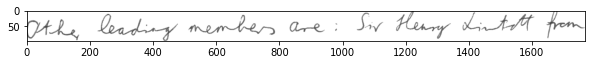

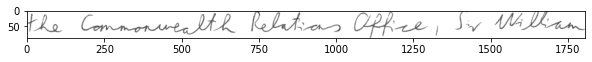

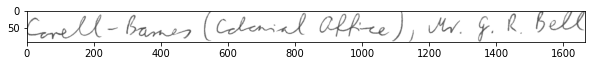

In [10]:
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [11]:
from sklearn.model_selection import train_test_split

train_files, test_files, train_labels, test_labels = train_test_split(
        img_files, img_labels, train_size=0.75, random_state=22, shuffle=True, stratify=img_labels)

In [12]:
np.unique(test_labels),np.unique(train_labels),train_files.shape,test_files.shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 (2882,),
 (961,))

In [13]:
validation_files, test_files, validation_labels, test_labels = train_test_split(
        test_files, test_labels, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_labels.shape, validation_labels.shape, test_labels.shape)

(2882,) (480,) (481,)
(2882,) (480,) (481,)


In [14]:
from data_prep import prep_sample

# # Now create generators for randomly cropping 113x113 patches from these images

batch_size = 16

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                prep_sample(batch_sample, batch_target, images, targets, factor=factor)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255
            
            X_train, y_train=  shuffle(X_train, y_train)

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)

            yield X_train, y_train
            

In [15]:
import tensorflow as tf
dropout_rate = 0.1

class CustomSchedule(LearningRateSchedule):
  def __init__(self, d_model=50, warmup_steps=1000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [16]:
# Generate data for training and validation
train_generator = generate_data(train_files, train_labels, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_labels, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_labels, batch_size=batch_size, factor = 0.1)

In [17]:
model = build_model(num_classes)
model.compile(loss='categorical_crossentropy', optimizer=Adam(CustomSchedule()), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 115, 115, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 58, 58, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 58, 58, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 29, 29, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 29, 29, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 29, 29, 64)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 64)        0

In [ ]:
# Train the model 

nb_epoch = 8

samples_per_epoch =3268
nb_val_samples = 842

#model.load_weights('/opt/data/writer_id_check/points/check-08-1.7336.hdf5')

#save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
filepath="/opt/data/writer_id_check/points/check-2-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, save_weights_only=True, save_best_only=False)
callbacks_list = [checkpoint]

#steps_per_epoch=None, epochs=1, verbose=1, callbacks=None,
#    validation_data=None, validation_steps=None, validation_freq=1,
#    class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False,
#    shuffle=True, initial_epoch=0
#Model fit generator
history_object = model.fit_generator(train_generator, 
                                     steps_per_epoch = samples_per_epoch,
                                     validation_data =validation_generator,
                                     validation_steps =nb_val_samples, 
                                     epochs =nb_epoch, 
                                     callbacks =callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/8
 151/3268 [>.............................] - ETA: 3:07:19 - loss: 3.6303 - accuracy: 0.2001

In [220]:
# Load save model and use for prediction on test set
model.load_weights('checkpoint2/check-08-0.1399.hdf5')
scores = model.evaluate_generator(test_generator,842) 
print("Accuracy = ", scores[1])

Accuracy =  0.9608365297317505
